## MSDS AI Capstone: Visual QUestion Answering on Chart Data
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

Images in the FigureQA dataset are comprised on five types of figures commonly found in analytical documents. Fifteen question types were selected for the dataset concerning quantitative attributes in relational global and one-vs-one contexts. These include properties like minimum and maximum, greater and less than, medians, curve roughness, and area under the curve (AUC). All questions in the training and validation sets have either a yes or no answer.

<div class="alert alert-block alert-info">
<b>The FigureQA dataset</b><br>
https://www.microsoft.com/en-us/research/project/figureqa-dataset/
    </div>

## Imports

In [1]:
import numpy as np
import pandas as pd
from packaging import version
import datetime
import time
import json

import os

from sklearn.manifold import TSNE

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import nltk
nltk.download('punkt')
import re
import string
from nltk.tokenize import word_tokenize

import math
from itertools import permutations
from scipy.stats import rankdata

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import torch
from torchvision import transforms

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Mount Google Cloud Sotrage Bucket to Colab Environment

Follow the isntructions here: https://colab.research.google.com/notebooks/snippets/gcs.ipynb#scrollTo=X0WH8rvDBtiG

Decided to use a GCP bucket instead of google drive because the train data has 100K images, which crashed the Google Drive mount in Colab


First, open run the following commands in a code block. The code will return a link for you to log in as a gmail user, and copy an verification code to authenticate yourself.

In [4]:
from google.colab import auth

auth.authenticate_user()

project_id = 'msds-ai-capstone-chart-vqa'
!gcloud config set project {project_id}

Updated property [core/project].


You can use Cloud Storage FUSE to mount a Cloud Storage location to access it directly as a local filesystem path.

Run the following commands to install gcsfuse.

In [5]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  30787      0 --:--:-- --:--:-- --:--:-- 30918
OK
9 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 9 not upgraded.
Need to get 5,561 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../gcsfuse_1.2.1_amd64.deb ...
Unpacking gcsfuse (1.2.1) ...
Setting up gc

In [6]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "dynamic-chart-vqa-train-data"  # or a location like "my-bucket/path/to/mount"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"time":"19/11/2023 07:51:56.400300","severity":"INFO","msg":"Start gcsfuse/1.2.1 (Go version go1.21.3) for app \"\" using mount point: /mnt/gs/dynamic-chart-vqa-train-data\n"}


In [7]:
# Then you can access it like a local path.
!ls -lh {local_path}

total 98M
drwxr-xr-x 1 root root   0 Nov 19 07:51 configs
drwxr-xr-x 1 root root   0 Nov 19 07:51 experiments
drwxr-xr-x 1 root root   0 Nov 19 07:51 models
-rw-r--r-- 1 root root 98M Jan 16  2021 pretrained.tar.gz
drwxr-xr-x 1 root root   0 Nov 19 07:51 sample_train1
drwxr-xr-x 1 root root   0 Nov 19 07:51 test
drwxr-xr-x 1 root root   0 Nov 19 07:51 train1
drwxr-xr-x 1 root root   0 Nov 19 07:51 validation1


## Import the Trainign and Validation Data generated from the 'Part 1' notebook


In [8]:
import json

In [9]:
# training data
# Change working directory to the GCS mount
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


with open('encoded_train_questions_final.json') as f:
    encoded_train_questions_final = np.asarray(json.load(f))

with open('encoded_train_answers_final.json') as f:
    encoded_train_answers_final = np.asarray(json.load(f))

with open('train_images_fnames_to_keep.json') as f:
    train_image_fnames_to_keep = np.asarray(json.load(f))


In [10]:
#validation data
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

with open('encoded_val_questions_final.json') as f:
    encoded_val_questions_final = np.asarray(json.load(f))

with open('encoded_val_answers_final.json') as f:
    encoded_val_answers_final = np.asarray(json.load(f))

with open('val_image_fnames_to_keep.json') as f:
    val_image_fnames_to_keep = np.asarray(json.load(f))

In [11]:
# creating indexes for the train and valudation datasets

#first the train dataset index
train_index = np.arange(encoded_train_answers_final.shape[0]) # create index array for indexing

#second the val dataset index
val_index = np.arange(encoded_val_answers_final.shape[0]) # create index array for indexing

# Build Training and Validation tensor with batches.
And resize the images

Using a modified version fo the code here: https://www.kaggle.com/code/marcelosabaris/visualquestionanswering

alongside with the parameters from the PreFil repo here: https://github.com/kushalkafle/PReFIL/blob/main/configs/config_FigureQA.py

In [ ]:

BATCH_SIZE=64
IMG_SIZE=(224,320) #using the PreFil config details (https://github.com/kushalkafle/PReFIL/blob/main/configs/config_FigureQA.py)

from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
from torch.utils.data import Dataset

os.chdir('/')

data_transform = transforms.Compose([
    transforms.Resize((224, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9365, 0.9303, 0.9295],
                         std=[1, 1, 1])])

def encode_answers(answer):
  a = torch.zeros((1,))
  if answer == 1:
    a[0] = 0.0
  elif answer == 0:
    a[0] = 1.0
  else:
    a[0] = 'something_wrong'
  return a

def collate_batch(data_batch):
    data_batch.sort(key=lambda x: x[-1], reverse=True)
    return torch.utils.data.dataloader.default_collate(data_batch)


class ImageDataset(Dataset):
    def __init__(self, image_fnames,encoded_question,encoded_answers,quest_index,split):
        self.image_fnames = image_fnames
        self.encoded_question = encoded_question
        self.encoded_answers = encoded_answers
        self.prep = data_transform
        self.split = split
        self.quest_index = quest_index

    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, index):
          question_tensor = torch.Tensor(self.encoded_question[index]).long()
          q_len = len(self.encoded_question[index])
          answer_tensor = encode_answers(self.encoded_answers[index])
          quest_index = self.quest_index[index]
          if 'train' in self.split:
            img_path = os.path.join('/mnt/gs/dynamic-chart-vqa-train-data/train1/png/',
                                  self.image_fnames[index])
            img = Image.open(img_path).convert('RGB')
            img_tensor = self.prep(img)
          else:
            img_path = os.path.join('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png/',
                                  self.image_fnames[index])
            img = Image.open(img_path).convert('RGB')
            img_tensor = self.prep(img)

          return img_tensor,question_tensor,answer_tensor,q_len, quest_index





#The tensor batched training Dataset object is created
train_df = ImageDataset(train_image_fnames_to_keep,encoded_train_questions_final,encoded_train_answers_final,train_index,'train') #Preprocessing function is applied to the dataset
train_dataset=DataLoader(train_df,BATCH_SIZE,shuffle=True, collate_fn=collate_batch,num_workers=8)#The dataset is batched

#The tensor batched training Dataset object is created
val_df = ImageDataset(val_image_fnames_to_keep,encoded_val_questions_final,encoded_val_answers_final,val_index,'validation') #Preprocessing function is applied to the dataset
validation_dataset=DataLoader(val_df,BATCH_SIZE,shuffle=False, collate_fn=collate_batch,num_workers=8)#The dataset is batched



In [ ]:
#check how the train_dataset is build
next(iter(train_dataset))

[tensor([[[[ 0.0635,  0.0635,  0.0635,  ...,  0.0635,  0.0635,  0.0635],
           [ 0.0635,  0.0635,  0.0635,  ...,  0.0635,  0.0635,  0.0635],
           [ 0.0635,  0.0635,  0.0635,  ...,  0.0635,  0.0635,  0.0635],
           ...,
           [ 0.0635,  0.0635,  0.0635,  ...,  0.0635,  0.0635,  0.0635],
           [ 0.0635,  0.0635,  0.0635,  ...,  0.0635,  0.0635,  0.0635],
           [ 0.0635,  0.0635,  0.0635,  ...,  0.0635,  0.0635,  0.0635]],
 
          [[ 0.0697,  0.0697,  0.0697,  ...,  0.0697,  0.0697,  0.0697],
           [ 0.0697,  0.0697,  0.0697,  ...,  0.0697,  0.0697,  0.0697],
           [ 0.0697,  0.0697,  0.0697,  ...,  0.0697,  0.0697,  0.0697],
           ...,
           [ 0.0697,  0.0697,  0.0697,  ...,  0.0697,  0.0697,  0.0697],
           [ 0.0697,  0.0697,  0.0697,  ...,  0.0697,  0.0697,  0.0697],
           [ 0.0697,  0.0697,  0.0697,  ...,  0.0697,  0.0697,  0.0697]],
 
          [[ 0.0705,  0.0705,  0.0705,  ...,  0.0705,  0.0705,  0.0705],
           [ 

In [ ]:
#check how the val dataset is build
next(iter(validation_dataset))

[tensor([[[[0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
           [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
           [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
           ...,
           [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
           [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
           [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635]],
 
          [[0.0697, 0.0697, 0.0697,  ..., 0.0697, 0.0697, 0.0697],
           [0.0697, 0.0697, 0.0697,  ..., 0.0697, 0.0697, 0.0697],
           [0.0697, 0.0697, 0.0697,  ..., 0.0697, 0.0697, 0.0697],
           ...,
           [0.0697, 0.0697, 0.0697,  ..., 0.0697, 0.0697, 0.0697],
           [0.0697, 0.0697, 0.0697,  ..., 0.0697, 0.0697, 0.0697],
           [0.0697, 0.0697, 0.0697,  ..., 0.0697, 0.0697, 0.0697]],
 
          [[0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
           [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
           [0.0705, 0.07

# VQA Model

to read, telling us how to implemente the RN network and ow it will take 12 days to run: https://github.com/mcogswell/figqa-pytorch

priginal paper, which contains ntes on limitations ans such: https://www.microsoft.com/en-us/research/blog/figureqa-annotated-figure-dataset-visual-reasoning/


pretrained PREFil model for figureQA: https://github.com/kushalkafle/PReFIL/tree/main/data

### Congig Parameters (cna be tweaked)

In [ ]:
# Model Details

word_emb_dim = 32
ques_lstm_out = 256
num_hidden_act = 1024
num_rf_out = 256
num_bimodal_units = 256
q_len = 9 #question lenght
n1 = 51 #dictionnary lenght + 1

image_encoder = 'dense'

if image_encoder == 'dense':
    densenet_config = (6, 6, 6)
    densenet_dim = [128, 160, 352] # Might be nice to compute according to densenet_config



# Training/Optimization

root = '/mnt/gs/dynamic-chart-vqa-train-data'
optimizer = torch.optim.Adamax
test_interval = 5  # In epochs
test_every_epoch_after = 20
max_epochs = 10
overwrite_expt_dir = False  # For convenience, set to True while debugging
grad_clip = 50

# Parameters for learning rate schedule

#lr = 7e-4
#updating the learning rate to this instead because I trained the modle several times so did not really start at epoch 1 but rather at the equivalent of epoch 10.
#if starting this from scratch, start with the normal starting learnign rate instead
lr = 7e-4*.7*.7*.7*.7*.7
lr_decay_step = 2  # Decay every this many epochs
lr_decay_rate = .7
lr_decay_epochs = range(15, 25, lr_decay_step)
lr_warmup_steps = [0.5 * lr, 1.0 * lr, 1.0 * lr, 1.5 * lr, 2.0 * lr]
dropout_classifier = True

### Build the model

In [ ]:
#inpo: https://github.com/kushalkafle/PReFIL/tree/main

from collections import OrderedDict

from torch import nn
from torchvision.models.densenet import _DenseBlock, _Transition
from torch.nn.utils.rnn import pack_padded_sequence




# Denset Net Model

class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self, growth_rate=32, block_config=(6, 6, 6),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet, self).__init__()
        self.block_config = block_config
        # First convolution
        self.first_conv = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        self.denseblock = []
        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)

            self.denseblock.append(nn.Sequential(OrderedDict([
                (f'dblock{i}', block),
            ])))
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.denseblock[i].add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.final_bn = nn.BatchNorm2d(num_features)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

        self.denseblock = nn.ModuleList(self.denseblock)

    def forward(self, x):
        first_conv_feat = self.first_conv(x)
        denseblock_feat = [self.denseblock[0](first_conv_feat)]

        for i in range(len(self.block_config) - 1):
            denseblock_feat.append(self.denseblock[i + 1](denseblock_feat[i]))
        final_feat = self.final_bn(denseblock_feat[-1])
        return first_conv_feat, denseblock_feat, final_feat


############################################
#Rest of the model architecure

class QuestionEncoder(nn.Module):
    def __init__(self, num_tokens):
        super(QuestionEncoder, self).__init__()
        self.embedding = nn.Embedding(num_tokens, word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim,
                            hidden_size=ques_lstm_out,
                            num_layers=1)

    def forward(self, q,q_len=9):
        q_embed = self.embedding(q)
        packed = pack_padded_sequence(q_embed, q_len.to('cpu'), batch_first=True)
        o, (h, c) = self.lstm(packed)
        return c.squeeze(0)


class DenseNetEncoder(nn.Module):
    def __init__(self, densenet_config):
        super(DenseNetEncoder, self).__init__()
        self.densenet = DenseNet(block_config=densenet_config).cuda()

    def forward(self, img):
        _, dense, final = self.densenet(img)
        return dense[0], dense[1], final


class BimodalEmbedding(nn.Module):
    def __init__(self, num_mmc_units, ques_dim, img_dim, num_mmc_layers=4):
        super(BimodalEmbedding, self).__init__()
        self.bn = nn.BatchNorm2d(ques_dim + img_dim)
        self.transform_convs = []
        self.num_mmc_layers = num_mmc_layers
        self.transform_convs.append(nn.Conv2d(ques_dim + img_dim, num_mmc_units, kernel_size=1))
        self.transform_convs.append(nn.ReLU())
        for i in range(num_mmc_layers - 1):
            self.transform_convs.append(nn.Conv2d(num_mmc_units, num_mmc_units, kernel_size=1))
            self.transform_convs.append(nn.ReLU())
        self.transform_convs = nn.Sequential(*self.transform_convs)

    def forward(self, img_feat, ques_feat):
        # Tile ques_vector, concatenate
        _, _, nw, nh = img_feat.shape
        _, qdim = ques_feat.shape
        ques_feat = ques_feat.unsqueeze(2)
        ques_tile = ques_feat.repeat(1, 1, nw * nh)
        ques_tile = ques_tile.view(-1, qdim, nw, nh)
        combine_feat = self.bn(torch.cat([img_feat, ques_tile], dim=1))
        bimodal_emb = self.transform_convs(combine_feat)
        return bimodal_emb


class Classifier(nn.Module):
    def __init__(self, num_classes, feat_in):
        super(Classifier, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.lin1 = nn.Linear(feat_in, num_hidden_act)
        self.classifier = nn.Linear(num_hidden_act, num_classes)
        self.drop = nn.Dropout()
        self.use_drop = dropout_classifier

    def forward(self, bimodal_emb):
        # Tile ques_vector, concatenate
        projection = self.relu(self.lin1(bimodal_emb))
        if self.use_drop:
            projection = self.drop(projection)
        preds = self.classifier(projection)
        return preds


class RecurrentFusion(nn.Module):
    def __init__(self, num_bigru_units, feat_in):
        super(RecurrentFusion, self).__init__()
        self.bigru = nn.GRU(input_size=feat_in,
                            hidden_size=num_bigru_units,
                            batch_first=True,
                            bidirectional=True)

    def forward(self, mmc_feat):
        _, fs, nw, nh = mmc_feat.shape
        mmc_feat = mmc_feat.view(-1, fs, nw * nh)
        mmc_feat = torch.transpose(mmc_feat, 1, 2)
        output, h = self.bigru(mmc_feat)
        return torch.flatten(torch.transpose(h, 0, 1), start_dim=1)


class BasePReFIL(nn.Module):
    def __init__(self, num_tokens):
        super(BasePReFIL, self).__init__()
        self.rnn = QuestionEncoder(num_tokens)
        self.cnn = DenseNetEncoder(densenet_config)
        img_dims = densenet_dim
        self.bimodal_low = BimodalEmbedding(num_bimodal_units, ques_lstm_out, img_dims[0])
        self.bimodal_high = BimodalEmbedding(num_bimodal_units, ques_lstm_out, img_dims[2])
        self.maxpool_low = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)

    @staticmethod
    def flatten_to_2d(mmc_feat):
        return mmc_feat.reshape(-1, mmc_feat.shape[1] * mmc_feat.shape[2] * mmc_feat.shape[3])

    def forward(self, img, ques,q_len):
        ques_feat = self.rnn(ques, q_len)
        feat_low, feat_mid, feat_high = self.cnn(img)
        feat_low = self.maxpool_low(feat_low)
        bimodal_feat_low = self.bimodal_low(feat_low, ques_feat)
        bimodal_feat_high = self.bimodal_high(feat_high, ques_feat)
        return bimodal_feat_low, bimodal_feat_high


class PReFIL(BasePReFIL):
    def __init__(self, num_tokens, num_ans_classes):
        super(PReFIL, self).__init__(num_tokens)
        self.rf_low = RecurrentFusion(num_rf_out, num_bimodal_units)
        self.rf_high = RecurrentFusion(num_rf_out, num_bimodal_units)
        self.classifier = Classifier(num_ans_classes, num_rf_out * 4)

    def forward(self, img, ques,q_len):
        bimodal_feat_low, bimodal_feat_high = super(PReFIL, self).forward(img, ques, q_len)
        rf_feat_low = self.rf_low(bimodal_feat_low)
        rf_feat_high = self.rf_high(bimodal_feat_high)
        final_feat = torch.cat([rf_feat_low, rf_feat_high], dim=1)
        answer = self.classifier(final_feat)
        return answer


def main():
    pass


if __name__ == '__main___':
    main()


## Train the Model

In [ ]:
#downlaod the pretrained model (optional, did not end up using this)
#then need to unzip them and save them under the /experiments/ folder if we want to use them in the code
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MMVtvhFCgDNdF4RalzRwlGMQ4D5qNqVE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MMVtvhFCgDNdF4RalzRwlGMQ4D5qNqVE" -O pretrained.tar.gz && rm -rf /tmp/cookies.txt

--2023-10-31 02:38:03--  https://docs.google.com/uc?export=download&confirm=t&id=1MMVtvhFCgDNdF4RalzRwlGMQ4D5qNqVE
Resolving docs.google.com (docs.google.com)... 172.217.194.101, 172.217.194.138, 172.217.194.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/isqa5k9mtgfnv1lsh89jmod5dfdlk704/1698719850000/05028220109015226717/*/1MMVtvhFCgDNdF4RalzRwlGMQ4D5qNqVE?e=download&uuid=47a6a3e6-72ab-4e34-af42-3e1a5bb07eed [following]
--2023-10-31 02:38:03--  https://doc-0g-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/isqa5k9mtgfnv1lsh89jmod5dfdlk704/1698719850000/05028220109015226717/*/1MMVtvhFCgDNdF4RalzRwlGMQ4D5qNqVE?e=download&uuid=47a6a3e6-72ab-4e34-af42-3e1a5bb07eed
Resolving doc-0g-0s-docs.googleusercontent.com (doc-0g-0s-docs.googleusercontent.com)... 74.125.130.1

In [ ]:
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data')

In [ ]:
import argparse
import json
import os
import shutil
import sys
import torch
import torch.nn as nn


parser = argparse.ArgumentParser()
parser.add_argument('--evaluate', action='store_true')
parser.add_argument('--resume', action='store_true')
parser.add_argument('--expt_name', required=True, type=str)
parser.add_argument('--data_root', default='/mnt/gs/dynamic-chart-vqa-train-data', type=str)


#if we wanted to start from a pretrained model from the github repo at https://github.com/kushalkafle/PReFIL/blob/main
#args = parser.parse_args(args=['--resume','--expt_name','FigureQA_pretrained', '--data_root', '/mnt/gs/dynamic-chart-vqa-train-data'])

#trainign a new model for the first time
#args = parser.parse_args(args=['--expt_name','PreFil_Model_2', '--data_root', '/mnt/gs/dynamic-chart-vqa-train-data'])


# resumign training on the same model for a few more epoch
max_epochs = 11 #nummber of max epoch to do the trainign for (make sure to check that it is higher than the current epoch if you are resumeing training)
args = parser.parse_args(args=['--resume','--expt_name','PreFil_Model_2', '--data_root', '/mnt/gs/dynamic-chart-vqa-train-data'])



EXPT_DIR = os.path.join(args.data_root, 'experiments', args.expt_name)


#removing this because we dont have a separate config file to maintain, instead we defined the training parameters (lr, epoch, etc.) in the code block under 'Build Model' section in this notebook
#if args.evaluate or args.resume:
#    if os.path.exists(EXPT_DIR):
#        shutil.copy(os.path.join(EXPT_DIR, f'config_{args.expt_name}.py'), f'configs/config_{args.expt_name}.py')
#    else:
#        sys.exit("Experiment Folder does not exist")

#exec(f'import configs.config_{args.expt_name} as CONFIG')
#CONFIG.root = args.data_root





def inline_print(text):
    """
    A simple helper to print text inline. Helpful for displaying training progress among other things.
    Args:
        text: Text to print inline
    """
    sys.stdout.write('\r' + text)
    sys.stdout.flush()


def fit(net, dataloader, criterion, optimizer, epoch):
    """
    Train 1 epoch on the given dataloader and model

    Args:
        net: Model instance to train
        dataloader: dataset to use
        criterion: Training objective
        optimizer: Optimizer to use
        epoch: Current Epoch
    """

    net.train()
    correct = 0
    total = 0
    total_loss = 0
    for i, q, a, ql, qid in dataloader: #i is image tensor, q is question, a is answer, ql is question lenght, qid is the train index/question index
        q = q.cuda()
        i = i.cuda()
        ql = ql.cuda()
        a = a.cuda()
        p = net(i, q, ql)
        loss = criterion(p, a)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        optimizer.step()
        p_scale = torch.sigmoid(p)
        pred_class = p_scale >= 0.5
        c = float(torch.sum(pred_class.float() == a))
        correct += c
        total += len(ql)
        total_loss += loss * len(ql)
        inline_print(
            f'Running {dataloader.dataset.split}, Processed {total} of {len(dataloader) * dataloader.batch_size} '
            f'Accuracy: {correct / total}, Loss: {total_loss / total}')

    print(f'\nTrain Accuracy for Epoch {epoch + 1}: {correct / total}')


def predict(net, dataloaders, epoch):
    """
    Evaluate 1 epoch on the given list of dataloaders and model, prints accuracy and saves predictions

    Args:
        net: Model instance to train
        dataloaders: List of datasets to use
        epoch: Current Epoch
    """
    net.eval()
    #for data in dataloaders: #dontneed this because I am not passing both a test_dataset and a validaiton_dataset (only doing validation_dataset). then uncommenting au subsequent mention of 'data' and replacing by dataloaders'
    correct = 0
    total = 0
    results = dict()
    with torch.no_grad():
        #for i, q, a, ql in data: #i is image tensor, q is question, a i
        for i, q, a, ql, qid in dataloaders: #i is image tensor, q is question, a is answer, ql is question lenght, qid is the question index/dataste index
            q = q.cuda()
            i = i.cuda()
            ql = ql.cuda()
            a = a.cuda()
            p = net(i, q, ql)
            _, idx = p.max(dim=1)
            p_scale = torch.sigmoid(p)
            pred_class = p_scale >= 0.5
            c = float(torch.sum(pred_class.float() == a))
            for qqid, curr_pred_class in zip(qid, pred_class):
              qqid = int(qqid.item())
              if qqid not in results:
                results[qqid] = int(curr_pred_class)
            correct += c
            total += len(ql)
            #print_str = f'Running {data.dataset.split}, Processed {total} of {len(data) * data.batch_size} '
            print_str = f'Running {dataloaders.dataset.split}, Processed {total} of {len(dataloaders) * dataloaders.batch_size} '
            #if 'test' not in data.dataset.split:
            if 'test' not in dataloaders.dataset.split:
                inline_print(print_str + f'Accuracy: {correct / total}')
            else:
                inline_print(print_str)

    #result_file = os.path.join(EXPT_DIR, f'results_{data.dataset.split}_{epoch + 1}.json')
    result_file = os.path.join(EXPT_DIR, f'results_{dataloaders.dataset.split}_{epoch + 1}.json')
    json.dump(results, open(result_file, 'w'))
    print(f"Saved {result_file}")
    #if 'test' not in data.dataset.split:
    if 'test' not in dataloaders.dataset.split:
        #print(f'\n{data.dataset.split} Accuracy for Epoch {epoch + 1}: {correct / total}')
        print(f'\n{dataloaders.dataset.split} Accuracy for Epoch {epoch + 1}: {correct / total}')


def make_experiment_directory():
    #if not args.evaluate and not args.resume and not overwrite_expt_dir:
    if not args.evaluate and not args.resume:
        if os.path.exists(EXPT_DIR):
            raise RuntimeError(f'Experiment directory {EXPT_DIR} already exists, '
                               f'and the config is set to do not overwrite')

    if not os.path.exists(EXPT_DIR):
        os.makedirs(EXPT_DIR)


def update_learning_rate(epoch, optimizer):
    if epoch < len(lr_warmup_steps):
        optimizer.param_groups[0]['lr'] = lr_warmup_steps[epoch]
    elif epoch in lr_decay_epochs:
        optimizer.param_groups[0]['lr'] *= lr_decay_rate


def training_loop(net, train_loader, val_loaders, optimizer, criterion, start_epoch=0):
    for epoch in range(start_epoch, max_epochs):
        update_learning_rate(epoch, optimizer)
        fit(net, train_loader, criterion, optimizer, epoch)
        curr_epoch_path = os.path.join(EXPT_DIR, str(epoch + 1) + '.pth')
        latest_path = os.path.join(EXPT_DIR, 'latest.pth')
        data = {'model_state_dict': net.state_dict(),
                'optim_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'lr': optimizer.param_groups[0]['lr']}
        torch.save(data, curr_epoch_path)
        torch.save(data, latest_path)

        if epoch % test_interval == 0 or epoch >= test_every_epoch_after:
            predict(net, val_loaders, epoch)
            #predict(net, test_loaders, epoch)


def evaluate_saved(net, dataloader):
    weights_path = os.path.join(EXPT_DIR, 'latest.pth')
    saved = torch.load(weights_path)
    net.eval()
    net.load_state_dict(saved['model_state_dict'])
    predict(net, dataloader, saved['epoch'])


# %%
def main():
    make_experiment_directory()
    #print('Building Dataloaders according to configuration')

    if args.evaluate or args.resume:
    #    lut_location = os.path.join(EXPT_DIR, 'LUT.json')
        train_data = train_dataset
        val_data = validation_dataset
    else:
        train_data = train_dataset
        val_data = validation_dataset
    #    lut_dict = {'ans2idx': train_data.dataset.ans2idx,
    #                'ques2idx': train_data.dataset.ques2idx,
    #                'maxlen': train_data.dataset.maxlen}
    #    json.dump(lut_dict, open(os.path.join(EXPT_DIR, 'LUT.json'), 'w'))
    #    shutil.copy(f'configs/config_{args.expt_name}.py',
    #                os.path.join(EXPT_DIR, 'config_' + args.expt_name + '.py'))

    print('Building model to train: ')
    net = PReFIL(n1, 1)

    print("Model Overview: ")
    print(net)
    net.cuda()
    start_epoch = 0
    if not args.evaluate:
        print('Training...')
        #optimizer = optimizer(net.parameters(), lr=lr)
        optimizer = torch.optim.Adamax(net.parameters(), lr=7e-4)
        criterion = torch.nn.CrossEntropyLoss()
        criterion = nn.BCEWithLogitsLoss()

        if args.resume:
            resumed_data = torch.load(os.path.join(EXPT_DIR, 'latest.pth'))
            print(f"Resuming from epoch {resumed_data['epoch'] + 1}")
            net.load_state_dict(resumed_data['model_state_dict'])
            #optimizer = optimizer(net.parameters(), lr=resumed_data['lr'])
            optimizer = torch.optim.Adamax(net.parameters(), lr=resumed_data['lr'])
            optimizer.load_state_dict(resumed_data['optim_state_dict'])
            start_epoch = resumed_data['epoch']
        training_loop(net,
                      train_data,
                      val_data,
                      #test_data,
                      optimizer, criterion, start_epoch)

    else:
        print('Evaluating...')
        #evaluate_saved(net, test_data)
        evaluate_saved(net, val_data)


if __name__ == "__main__":
    main()




Building model to train: 
Model Overview: 
PReFIL(
  (rnn): QuestionEncoder(
    (embedding): Embedding(51, 32)
    (lstm): LSTM(32, 256)
  )
  (cnn): DenseNetEncoder(
    (densenet): DenseNet(
      (first_conv): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (final_bn): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (denseblock): ModuleList(
        (0): Sequential(
          (dblock0): _DenseBlock(
            (denselayer1): _DenseLayer(
              (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): ReLU(inplace=True)
              (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1)

# Inspect Validation Results

In [12]:
#download the predictions
import json
# Change working directory to the location of the prediction result file
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/experiments/PreFil_Model_2')


with open('results_validation_10.json') as f: #this is the validation for the latest epoch we trained on which is epoch 10, make sure to update this if we train further
    result_validation_images = (json.load(f))

#also laod up the validation question in theirnatural language format
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

with open('val_questions_final.json') as f:
    val_questions_final = np.asarray(json.load(f))

In [13]:
d = {"question_index":val_index,"image":val_image_fnames_to_keep,"question":val_questions_final,"question_encoded":list(encoded_val_questions_final),"actual_answer":encoded_val_answers_final}
df = pd.DataFrame(d).sort_index()
df

,question_index,image,question,question_encoded,actual_answer
0,0,0.png,Is Light Slate the minimum?,"[30, 2, 31, 32, 0, 0, 0, 0, 0]",1
1,1,0.png,Is Dark Turquoise the maximum?,"[30, 1, 31, 33, 0, 0, 0, 0, 0]",1
2,2,0.png,Is Light Slate the maximum?,"[30, 2, 31, 33, 0, 0, 0, 0, 0]",0
3,3,0.png,Is Dark Turquoise greater than Light Slate?,"[30, 1, 34, 35, 2, 0, 0, 0, 0]",1
4,4,0.png,Is Light Slate less than Dark Turquoise?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",1
...,...,...,...,...,...
65576,65576,19999.png,Is Orange Red less than Medium Seafoam?,"[30, 1, 36, 35, 2, 0, 0, 0, 0]",0
65577,65577,19999.png,Is Medium Seafoam the high median?,"[30, 2, 31, 37, 38, 0, 0, 0, 0]",1
65578,65578,19999.png,Is Medium Seafoam the low median?,"[30, 2, 31, 39, 38, 0, 0, 0, 0]",1
65579,65579,19999.png,Is Blue the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",0


In [14]:
df_2 = pd.DataFrame.from_dict(result_validation_images, orient='index')
df_2.index = df_2.index.astype(int) #convert index to integer (it was a string)
df_2.rename(columns={0: "predicted_answer"},inplace=True) #name the column
df_2.replace({0:1, 1:0},inplace=True) #replace 0 by 1 and vice-versa because we inverted them before passing them into the VQA  model

In [15]:
actual_vs_predicted_validation_df = pd.merge(df, df_2, left_index=True, right_index=True)
actual_vs_predicted_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
0,0,0.png,Is Light Slate the minimum?,"[30, 2, 31, 32, 0, 0, 0, 0, 0]",1,1
1,1,0.png,Is Dark Turquoise the maximum?,"[30, 1, 31, 33, 0, 0, 0, 0, 0]",1,1
2,2,0.png,Is Light Slate the maximum?,"[30, 2, 31, 33, 0, 0, 0, 0, 0]",0,0
3,3,0.png,Is Dark Turquoise greater than Light Slate?,"[30, 1, 34, 35, 2, 0, 0, 0, 0]",1,1
4,4,0.png,Is Light Slate less than Dark Turquoise?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65576,65576,19999.png,Is Orange Red less than Medium Seafoam?,"[30, 1, 36, 35, 2, 0, 0, 0, 0]",0,0
65577,65577,19999.png,Is Medium Seafoam the high median?,"[30, 2, 31, 37, 38, 0, 0, 0, 0]",1,0
65578,65578,19999.png,Is Medium Seafoam the low median?,"[30, 2, 31, 39, 38, 0, 0, 0, 0]",1,1
65579,65579,19999.png,Is Blue the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",0,0


In [16]:
correct_predictions_validation_df = actual_vs_predicted_validation_df[actual_vs_predicted_validation_df['actual_answer'] == actual_vs_predicted_validation_df['predicted_answer']]
correct_predictions_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
0,0,0.png,Is Light Slate the minimum?,"[30, 2, 31, 32, 0, 0, 0, 0, 0]",1,1
1,1,0.png,Is Dark Turquoise the maximum?,"[30, 1, 31, 33, 0, 0, 0, 0, 0]",1,1
2,2,0.png,Is Light Slate the maximum?,"[30, 2, 31, 33, 0, 0, 0, 0, 0]",0,0
3,3,0.png,Is Dark Turquoise greater than Light Slate?,"[30, 1, 34, 35, 2, 0, 0, 0, 0]",1,1
4,4,0.png,Is Light Slate less than Dark Turquoise?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65575,65575,19999.png,Is Medium Seafoam greater than Orange Red?,"[30, 2, 34, 35, 1, 0, 0, 0, 0]",0,0
65576,65576,19999.png,Is Orange Red less than Medium Seafoam?,"[30, 1, 36, 35, 2, 0, 0, 0, 0]",0,0
65578,65578,19999.png,Is Medium Seafoam the low median?,"[30, 2, 31, 39, 38, 0, 0, 0, 0]",1,1
65579,65579,19999.png,Is Blue the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",0,0


In [17]:
incorrect_predictions_validation_df = actual_vs_predicted_validation_df[actual_vs_predicted_validation_df['actual_answer'] != actual_vs_predicted_validation_df['predicted_answer']]
incorrect_predictions_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
40,40,7.png,Is Aqua the high median?,"[30, 7, 31, 37, 38, 0, 0, 0, 0]",0,1
91,91,31.png,Does Light Gold have the minimum area under th...,"[40, 1, 41, 31, 32, 42, 43, 31, 44]",0,1
92,92,31.png,Does Light Gold have the maximum area under th...,"[40, 1, 41, 31, 33, 42, 43, 31, 44]",0,1
95,95,31.png,Is Dark Turquoise the smoothest?,"[30, 3, 31, 45, 0, 0, 0, 0, 0]",0,1
96,96,31.png,Is Dark Turquoise the roughest?,"[30, 3, 31, 46, 0, 0, 0, 0, 0]",0,1
...,...,...,...,...,...,...
65542,65542,19987.png,Is Dark Slate the low median?,"[30, 3, 31, 39, 38, 0, 0, 0, 0]",1,0
65569,65569,19999.png,Is Blue the minimum?,"[30, 3, 31, 32, 0, 0, 0, 0, 0]",1,0
65573,65573,19999.png,Is Orange Red greater than Medium Seafoam?,"[30, 1, 34, 35, 2, 0, 0, 0, 0]",1,0
65574,65574,19999.png,Is Medium Seafoam less than Orange Red?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",1,0


In [38]:
#percentage of correct answer on validation data
val_accuracy = len(correct_predictions_validation_df)/len(actual_vs_predicted_validation_df)
val_accuracy

0.8372241960323874

## Validation Results by Chart type

In [39]:
# load training data
import json
# Change working directory to the GCS mount
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')


with open('val_image_fnames_to_keep.json') as f:
    val_images_fnames_to_keep = np.asarray(json.load(f))

#extract the chart type from the annotation.json file (note: this file is actually formatted as a list of dictionnaries and not as a json object so we need a different etract ethod)
from operator import itemgetter

def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

with open('./annotations.json', 'r') as g:
#with open('./validation1/annotations.json', 'r') as g:
    val_chart_annotation = json.load(g)
val_chart_type = list(map(itemgetter('type'), val_chart_annotation))

val_image_indices_unique = [i['image_index'] for i in val_chart_annotation]
val_image_indices_unique = np.array(val_image_indices_unique)
val_image_fnames_unique = ['{}.png'.format(idx)
                              for idx in val_image_indices_unique]
val_image_fnames_unique = np.array(val_image_fnames_unique)

In [40]:
val_images_fnames_to_keep_unique = np.unique(val_images_fnames_to_keep)
val_chart_type_idx_to_keep = [j for j,i in enumerate(val_image_fnames_unique) if i in val_images_fnames_to_keep_unique]

In [41]:
#get the final list of encoded questions we're keeping
val_chart_type_final = [i for j,i in enumerate(val_chart_type) if j in val_chart_type_idx_to_keep]

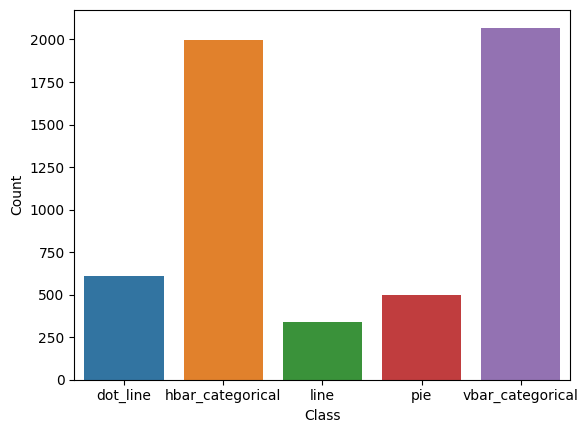

In [42]:
#Frequency of chart types in the val data, when we only look at images that we did not exclude during preprocessing in part 1 (so, images where OCR extraction worked)
Class, Count = np.unique(val_chart_type_final, return_counts=True)
count_data = {'Class': Class, 'Count': Count}
distribution = pd.DataFrame(count_data).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

### Pie Charts

In [26]:
#get the final list of pie chart file names that were kept in the validation dataset (fter we removed images whhere OCR extraction / question encoding failed)
pie_val_chart_type_final_fnames = [j for j,i in enumerate(val_chart_type) if (j in val_chart_type_idx_to_keep) and (i in 'pie')]

#format as .png filenames
pie_charts_val_dataset_fnames = ['{}.png'.format(idx)
                              for idx in pie_val_chart_type_final_fnames]

In [32]:
pie_chart_correct_prediction = [i for i in pie_charts_val_dataset_fnames if i in correct_predictions_validation_df['image'].tolist()]
#file names of pie chart with correct prediction
pie_chart_correct_prediction

['116.png',
 '200.png',
 '211.png',
 '262.png',
 '307.png',
 '337.png',
 '388.png',
 '435.png',
 '477.png',
 '480.png',
 '544.png',
 '570.png',
 '747.png',
 '808.png',
 '809.png',
 '816.png',
 '817.png',
 '829.png',
 '891.png',
 '917.png',
 '1010.png',
 '1043.png',
 '1047.png',
 '1062.png',
 '1082.png',
 '1115.png',
 '1143.png',
 '1229.png',
 '1254.png',
 '1296.png',
 '1348.png',
 '1394.png',
 '1453.png',
 '1469.png',
 '1489.png',
 '1503.png',
 '1545.png',
 '1575.png',
 '1599.png',
 '1624.png',
 '1678.png',
 '1681.png',
 '1720.png',
 '1744.png',
 '1788.png',
 '1823.png',
 '1887.png',
 '1902.png',
 '1920.png',
 '1950.png',
 '1987.png',
 '2050.png',
 '2146.png',
 '2288.png',
 '2290.png',
 '2338.png',
 '2363.png',
 '2511.png',
 '2526.png',
 '2585.png',
 '2650.png',
 '2737.png',
 '2743.png',
 '2774.png',
 '2775.png',
 '2876.png',
 '2879.png',
 '2914.png',
 '2924.png',
 '2948.png',
 '3145.png',
 '3152.png',
 '3171.png',
 '3203.png',
 '3220.png',
 '3366.png',
 '3402.png',
 '3403.png',
 '3413

In [34]:
#dataframe of pie chart image questions that were correctly answered
pie_charts_correct_predictions_validation_df = correct_predictions_validation_df[correct_predictions_validation_df['image'].isin(pie_chart_correct_prediction)]
pie_charts_correct_predictions_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
384,384,116.png,Is Saddle Brown the minimum?,"[30, 3, 31, 32, 0, 0, 0, 0, 0]",0,0
385,385,116.png,Is Blue Violet the maximum?,"[30, 2, 31, 33, 0, 0, 0, 0, 0]",0,0
388,388,116.png,Is Blue Violet greater than Saddle Brown?,"[30, 2, 34, 35, 3, 0, 0, 0, 0]",0,0
389,389,116.png,Is Saddle Brown less than Blue Violet?,"[30, 3, 36, 35, 2, 0, 0, 0, 0]",0,0
390,390,116.png,Is Dark Salmon the high median?,"[30, 1, 31, 37, 38, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65575,65575,19999.png,Is Medium Seafoam greater than Orange Red?,"[30, 2, 34, 35, 1, 0, 0, 0, 0]",0,0
65576,65576,19999.png,Is Orange Red less than Medium Seafoam?,"[30, 1, 36, 35, 2, 0, 0, 0, 0]",0,0
65578,65578,19999.png,Is Medium Seafoam the low median?,"[30, 2, 31, 39, 38, 0, 0, 0, 0]",1,1
65579,65579,19999.png,Is Blue the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",0,0


In [35]:
#dataframe of all pie chart related questions in the final val dataset
pie_charts_all_predictions_validation_df = actual_vs_predicted_validation_df[actual_vs_predicted_validation_df['image'].isin(pie_charts_val_dataset_fnames)]
pie_charts_all_predictions_validation_df


,question_index,image,question,question_encoded,actual_answer,predicted_answer
382,382,116.png,Is Blue Violet the minimum?,"[30, 2, 31, 32, 0, 0, 0, 0, 0]",1,0
383,383,116.png,Is Saddle Brown the maximum?,"[30, 3, 31, 33, 0, 0, 0, 0, 0]",1,0
384,384,116.png,Is Saddle Brown the minimum?,"[30, 3, 31, 32, 0, 0, 0, 0, 0]",0,0
385,385,116.png,Is Blue Violet the maximum?,"[30, 2, 31, 33, 0, 0, 0, 0, 0]",0,0
386,386,116.png,Is Saddle Brown greater than Blue Violet?,"[30, 3, 34, 35, 2, 0, 0, 0, 0]",1,0
...,...,...,...,...,...,...
65576,65576,19999.png,Is Orange Red less than Medium Seafoam?,"[30, 1, 36, 35, 2, 0, 0, 0, 0]",0,0
65577,65577,19999.png,Is Medium Seafoam the high median?,"[30, 2, 31, 37, 38, 0, 0, 0, 0]",1,0
65578,65578,19999.png,Is Medium Seafoam the low median?,"[30, 2, 31, 39, 38, 0, 0, 0, 0]",1,1
65579,65579,19999.png,Is Blue the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",0,0


In [37]:
# percentage of pie chart images questions that were correctly predicted
val_pie_chart_accuracy = len(pie_charts_correct_predictions_validation_df)/len(pie_charts_all_predictions_validation_df)
val_pie_chart_accuracy

0.549266247379455

### Line Charts

In [44]:
#get the final list of pie chart file names that were kept in the validation dataset (fter we removed images whhere OCR extraction / question encoding failed)
line_val_chart_type_final_fnames = [j for j,i in enumerate(val_chart_type) if (j in val_chart_type_idx_to_keep) and (i in 'line')]

#format as .png filenames
line_charts_val_dataset_fnames = ['{}.png'.format(idx)
                              for idx in line_val_chart_type_final_fnames]

In [45]:
line_chart_correct_prediction = [i for i in line_charts_val_dataset_fnames if i in correct_predictions_validation_df['image'].tolist()]
#file names of pie chart with correct prediction
line_chart_correct_prediction

['31.png',
 '57.png',
 '175.png',
 '185.png',
 '191.png',
 '267.png',
 '295.png',
 '386.png',
 '398.png',
 '472.png',
 '501.png',
 '510.png',
 '515.png',
 '541.png',
 '595.png',
 '863.png',
 '962.png',
 '966.png',
 '1020.png',
 '1068.png',
 '1168.png',
 '1175.png',
 '1177.png',
 '1237.png',
 '1334.png',
 '1429.png',
 '1441.png',
 '1510.png',
 '1512.png',
 '1566.png',
 '1581.png',
 '1722.png',
 '1774.png',
 '1783.png',
 '1817.png',
 '1855.png',
 '1877.png',
 '1882.png',
 '1889.png',
 '1911.png',
 '1926.png',
 '1942.png',
 '1953.png',
 '1984.png',
 '2083.png',
 '2100.png',
 '2189.png',
 '2239.png',
 '2304.png',
 '2388.png',
 '2601.png',
 '2617.png',
 '2628.png',
 '2637.png',
 '2676.png',
 '2823.png',
 '2945.png',
 '3008.png',
 '3173.png',
 '3181.png',
 '3296.png',
 '3374.png',
 '3495.png',
 '3564.png',
 '3664.png',
 '3704.png',
 '3729.png',
 '3745.png',
 '3817.png',
 '3854.png',
 '3921.png',
 '4016.png',
 '4111.png',
 '4206.png',
 '4207.png',
 '4239.png',
 '4274.png',
 '4281.png',
 '4583

In [46]:
#dataframe of pie chart image questions that were correctly answered
line_charts_correct_predictions_validation_df = correct_predictions_validation_df[correct_predictions_validation_df['image'].isin(line_chart_correct_prediction)]
line_charts_correct_predictions_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
89,89,31.png,Does Dark Turquoise have the minimum area unde...,"[40, 3, 41, 31, 32, 42, 43, 31, 44]",1,1
90,90,31.png,Does Medium Aqua have the maximum area under t...,"[40, 2, 41, 31, 33, 42, 43, 31, 44]",1,1
93,93,31.png,Is Medium Aqua the smoothest?,"[30, 2, 31, 45, 0, 0, 0, 0, 0]",1,1
94,94,31.png,Is Light Gold the roughest?,"[30, 1, 31, 46, 0, 0, 0, 0, 0]",1,1
97,97,31.png,Does Medium Aqua have the highest value?,"[40, 2, 41, 31, 49, 48, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65271,65271,19858.png,Does Periwinkle have the lowest value?,"[40, 2, 41, 31, 47, 48, 0, 0, 0]",1,1
65272,65272,19858.png,Does Medium Blue have the highest value?,"[40, 1, 41, 31, 49, 48, 0, 0, 0]",1,1
65273,65273,19858.png,Does Periwinkle intersect Medium Blue?,"[40, 2, 50, 1, 0, 0, 0, 0, 0]",1,1
65274,65274,19858.png,Is Periwinkle less than Medium Blue?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",0,0


In [47]:
#dataframe of all pie chart related questions in the final val dataset
line_charts_all_predictions_validation_df = actual_vs_predicted_validation_df[actual_vs_predicted_validation_df['image'].isin(line_charts_val_dataset_fnames)]
line_charts_all_predictions_validation_df


,question_index,image,question,question_encoded,actual_answer,predicted_answer
89,89,31.png,Does Dark Turquoise have the minimum area unde...,"[40, 3, 41, 31, 32, 42, 43, 31, 44]",1,1
90,90,31.png,Does Medium Aqua have the maximum area under t...,"[40, 2, 41, 31, 33, 42, 43, 31, 44]",1,1
91,91,31.png,Does Light Gold have the minimum area under th...,"[40, 1, 41, 31, 32, 42, 43, 31, 44]",0,1
92,92,31.png,Does Light Gold have the maximum area under th...,"[40, 1, 41, 31, 33, 42, 43, 31, 44]",0,1
93,93,31.png,Is Medium Aqua the smoothest?,"[30, 2, 31, 45, 0, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65271,65271,19858.png,Does Periwinkle have the lowest value?,"[40, 2, 41, 31, 47, 48, 0, 0, 0]",1,1
65272,65272,19858.png,Does Medium Blue have the highest value?,"[40, 1, 41, 31, 49, 48, 0, 0, 0]",1,1
65273,65273,19858.png,Does Periwinkle intersect Medium Blue?,"[40, 2, 50, 1, 0, 0, 0, 0, 0]",1,1
65274,65274,19858.png,Is Periwinkle less than Medium Blue?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",0,0


In [69]:
# percentage of pie chart images questions that were correctly predicted
line_chart_accuracy = len(line_charts_correct_predictions_validation_df)/len(line_charts_all_predictions_validation_df)
line_chart_accuracy

0.5827797649463464

### Dot Line Charts

In [49]:
#get the final list of pie chart file names that were kept in the validation dataset (fter we removed images whhere OCR extraction / question encoding failed)
dot_line_val_chart_type_final_fnames = [j for j,i in enumerate(val_chart_type) if (j in val_chart_type_idx_to_keep) and (i in 'dot_line')]

#format as .png filenames
dot_line_charts_val_dataset_fnames = ['{}.png'.format(idx)
                              for idx in dot_line_val_chart_type_final_fnames]

In [50]:
dot_line_chart_correct_prediction = [i for i in dot_line_charts_val_dataset_fnames if i in correct_predictions_validation_df['image'].tolist()]
#file names of pie chart with correct prediction
dot_line_chart_correct_prediction

['31.png',
 '39.png',
 '40.png',
 '57.png',
 '97.png',
 '103.png',
 '143.png',
 '175.png',
 '185.png',
 '191.png',
 '197.png',
 '201.png',
 '247.png',
 '267.png',
 '284.png',
 '295.png',
 '296.png',
 '297.png',
 '318.png',
 '325.png',
 '330.png',
 '348.png',
 '350.png',
 '386.png',
 '398.png',
 '404.png',
 '455.png',
 '472.png',
 '501.png',
 '510.png',
 '515.png',
 '530.png',
 '541.png',
 '559.png',
 '578.png',
 '587.png',
 '595.png',
 '625.png',
 '640.png',
 '672.png',
 '680.png',
 '683.png',
 '737.png',
 '761.png',
 '832.png',
 '863.png',
 '884.png',
 '928.png',
 '946.png',
 '962.png',
 '966.png',
 '987.png',
 '1020.png',
 '1028.png',
 '1041.png',
 '1059.png',
 '1061.png',
 '1068.png',
 '1079.png',
 '1089.png',
 '1116.png',
 '1154.png',
 '1157.png',
 '1168.png',
 '1171.png',
 '1175.png',
 '1177.png',
 '1199.png',
 '1226.png',
 '1237.png',
 '1280.png',
 '1302.png',
 '1321.png',
 '1334.png',
 '1351.png',
 '1380.png',
 '1429.png',
 '1438.png',
 '1441.png',
 '1460.png',
 '1466.png',
 '15

In [51]:
#dataframe of pie chart image questions that were correctly answered
dot_line_charts_correct_predictions_validation_df = correct_predictions_validation_df[correct_predictions_validation_df['image'].isin(dot_line_chart_correct_prediction)]
dot_line_charts_correct_predictions_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
89,89,31.png,Does Dark Turquoise have the minimum area unde...,"[40, 3, 41, 31, 32, 42, 43, 31, 44]",1,1
90,90,31.png,Does Medium Aqua have the maximum area under t...,"[40, 2, 41, 31, 33, 42, 43, 31, 44]",1,1
93,93,31.png,Is Medium Aqua the smoothest?,"[30, 2, 31, 45, 0, 0, 0, 0, 0]",1,1
94,94,31.png,Is Light Gold the roughest?,"[30, 1, 31, 46, 0, 0, 0, 0, 0]",1,1
97,97,31.png,Does Medium Aqua have the highest value?,"[40, 2, 41, 31, 49, 48, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65524,65524,19980.png,Is Light Coral the smoothest?,"[30, 1, 31, 45, 0, 0, 0, 0, 0]",1,1
65525,65525,19980.png,Is Web Gray the roughest?,"[30, 2, 31, 46, 0, 0, 0, 0, 0]",1,1
65527,65527,19980.png,Does Light Coral have the lowest value?,"[40, 1, 41, 31, 47, 48, 0, 0, 0]",1,1
65528,65528,19980.png,Does Light Coral have the highest value?,"[40, 1, 41, 31, 49, 48, 0, 0, 0]",1,1


In [52]:
#dataframe of all pie chart related questions in the final val dataset
dot_line_charts_all_predictions_validation_df = actual_vs_predicted_validation_df[actual_vs_predicted_validation_df['image'].isin(dot_line_charts_val_dataset_fnames)]
dot_line_charts_all_predictions_validation_df


,question_index,image,question,question_encoded,actual_answer,predicted_answer
89,89,31.png,Does Dark Turquoise have the minimum area unde...,"[40, 3, 41, 31, 32, 42, 43, 31, 44]",1,1
90,90,31.png,Does Medium Aqua have the maximum area under t...,"[40, 2, 41, 31, 33, 42, 43, 31, 44]",1,1
91,91,31.png,Does Light Gold have the minimum area under th...,"[40, 1, 41, 31, 32, 42, 43, 31, 44]",0,1
92,92,31.png,Does Light Gold have the maximum area under th...,"[40, 1, 41, 31, 33, 42, 43, 31, 44]",0,1
93,93,31.png,Is Medium Aqua the smoothest?,"[30, 2, 31, 45, 0, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65528,65528,19980.png,Does Light Coral have the highest value?,"[40, 1, 41, 31, 49, 48, 0, 0, 0]",1,1
65529,65529,19980.png,Does Web Gray have the highest value?,"[40, 2, 41, 31, 49, 48, 0, 0, 0]",0,1
65530,65530,19980.png,Does Web Gray intersect Light Coral?,"[40, 2, 50, 1, 0, 0, 0, 0, 0]",1,0
65531,65531,19980.png,Is Web Gray less than Light Coral?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",0,0


In [61]:
# percentage of pie chart images questions that were correctly predicted
dot_line_chart_accuracy = len(dot_line_charts_correct_predictions_validation_df)/len(dot_line_charts_all_predictions_validation_df)
dot_line_chart_accuracy

0.6014839636189564

### Horizontal Bar Charts

In [54]:
#get the final list of pie chart file names that were kept in the validation dataset (fter we removed images whhere OCR extraction / question encoding failed)
hbar_val_chart_type_final_fnames = [j for j,i in enumerate(val_chart_type) if (j in val_chart_type_idx_to_keep) and (i in 'hbar_categorical')]

#format as .png filenames
hbar_charts_val_dataset_fnames = ['{}.png'.format(idx)
                              for idx in hbar_val_chart_type_final_fnames]

In [55]:
hbar_chart_correct_prediction = [i for i in hbar_charts_val_dataset_fnames if i in correct_predictions_validation_df['image'].tolist()]
#file names of pie chart with correct prediction
hbar_chart_correct_prediction

['19.png',
 '30.png',
 '34.png',
 '53.png',
 '67.png',
 '68.png',
 '75.png',
 '78.png',
 '79.png',
 '84.png',
 '88.png',
 '93.png',
 '106.png',
 '119.png',
 '125.png',
 '135.png',
 '144.png',
 '152.png',
 '162.png',
 '163.png',
 '169.png',
 '179.png',
 '181.png',
 '182.png',
 '189.png',
 '196.png',
 '204.png',
 '245.png',
 '252.png',
 '258.png',
 '264.png',
 '280.png',
 '306.png',
 '312.png',
 '313.png',
 '316.png',
 '341.png',
 '345.png',
 '363.png',
 '365.png',
 '370.png',
 '376.png',
 '385.png',
 '387.png',
 '389.png',
 '420.png',
 '423.png',
 '459.png',
 '467.png',
 '470.png',
 '490.png',
 '509.png',
 '513.png',
 '521.png',
 '547.png',
 '585.png',
 '593.png',
 '613.png',
 '620.png',
 '629.png',
 '631.png',
 '632.png',
 '636.png',
 '648.png',
 '649.png',
 '651.png',
 '656.png',
 '657.png',
 '661.png',
 '665.png',
 '685.png',
 '700.png',
 '704.png',
 '705.png',
 '720.png',
 '722.png',
 '725.png',
 '732.png',
 '749.png',
 '759.png',
 '760.png',
 '769.png',
 '774.png',
 '776.png',
 '77

In [56]:
#dataframe of pie chart image questions that were correctly answered
hbar_charts_correct_predictions_validation_df = correct_predictions_validation_df[correct_predictions_validation_df['image'].isin(hbar_chart_correct_prediction)]
hbar_charts_correct_predictions_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
53,53,19.png,Is Web Green the minimum?,"[30, 5, 31, 32, 0, 0, 0, 0, 0]",1,1
54,54,19.png,Is Dark Gray the maximum?,"[30, 1, 31, 33, 0, 0, 0, 0, 0]",1,1
55,55,19.png,Is Slate the minimum?,"[30, 4, 31, 32, 0, 0, 0, 0, 0]",0,0
56,56,19.png,Is Slate the maximum?,"[30, 4, 31, 33, 0, 0, 0, 0, 0]",0,0
57,57,19.png,Is Slate greater than Web Green?,"[30, 4, 34, 35, 5, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65564,65564,19995.png,Is Dark Cyan less than Black?,"[30, 4, 36, 35, 3, 0, 0, 0, 0]",0,0
65565,65565,19995.png,Is Black the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",1,1
65566,65566,19995.png,Is Web Maroon the low median?,"[30, 2, 31, 39, 38, 0, 0, 0, 0]",1,1
65567,65567,19995.png,Is Web Maroon the high median?,"[30, 2, 31, 37, 38, 0, 0, 0, 0]",0,0


In [59]:
#dataframe of all pie chart related questions in the final val dataset
hbar_charts_all_predictions_validation_df = actual_vs_predicted_validation_df[actual_vs_predicted_validation_df['image'].isin(hbar_charts_val_dataset_fnames)]
hbar_charts_all_predictions_validation_df


,question_index,image,question,question_encoded,actual_answer,predicted_answer
53,53,19.png,Is Web Green the minimum?,"[30, 5, 31, 32, 0, 0, 0, 0, 0]",1,1
54,54,19.png,Is Dark Gray the maximum?,"[30, 1, 31, 33, 0, 0, 0, 0, 0]",1,1
55,55,19.png,Is Slate the minimum?,"[30, 4, 31, 32, 0, 0, 0, 0, 0]",0,0
56,56,19.png,Is Slate the maximum?,"[30, 4, 31, 33, 0, 0, 0, 0, 0]",0,0
57,57,19.png,Is Slate greater than Web Green?,"[30, 4, 34, 35, 5, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65564,65564,19995.png,Is Dark Cyan less than Black?,"[30, 4, 36, 35, 3, 0, 0, 0, 0]",0,0
65565,65565,19995.png,Is Black the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",1,1
65566,65566,19995.png,Is Web Maroon the low median?,"[30, 2, 31, 39, 38, 0, 0, 0, 0]",1,1
65567,65567,19995.png,Is Web Maroon the high median?,"[30, 2, 31, 37, 38, 0, 0, 0, 0]",0,0


In [60]:
# percentage of pie chart images questions that were correctly predicted
hbar_chart_accuracy = len(hbar_charts_correct_predictions_validation_df)/len(hbar_charts_all_predictions_validation_df)
hbar_chart_accuracy

0.9336887986119927

### Vertical Bar Charts

In [62]:
#get the final list of pie chart file names that were kept in the validation dataset (fter we removed images whhere OCR extraction / question encoding failed)
vbar_val_chart_type_final_fnames = [j for j,i in enumerate(val_chart_type) if (j in val_chart_type_idx_to_keep) and (i in 'vbar_categorical')]

#format as .png filenames
vbar_charts_val_dataset_fnames = ['{}.png'.format(idx)
                              for idx in vbar_val_chart_type_final_fnames]

In [63]:
vbar_chart_correct_prediction = [i for i in vbar_charts_val_dataset_fnames if i in correct_predictions_validation_df['image'].tolist()]
#file names of pie chart with correct prediction
vbar_chart_correct_prediction

['0.png',
 '2.png',
 '6.png',
 '7.png',
 '17.png',
 '24.png',
 '32.png',
 '36.png',
 '38.png',
 '50.png',
 '77.png',
 '81.png',
 '113.png',
 '123.png',
 '148.png',
 '159.png',
 '164.png',
 '168.png',
 '184.png',
 '198.png',
 '208.png',
 '238.png',
 '246.png',
 '255.png',
 '281.png',
 '289.png',
 '292.png',
 '293.png',
 '304.png',
 '305.png',
 '308.png',
 '324.png',
 '326.png',
 '335.png',
 '342.png',
 '344.png',
 '359.png',
 '394.png',
 '425.png',
 '432.png',
 '441.png',
 '451.png',
 '453.png',
 '463.png',
 '474.png',
 '476.png',
 '494.png',
 '495.png',
 '496.png',
 '506.png',
 '507.png',
 '512.png',
 '516.png',
 '522.png',
 '532.png',
 '548.png',
 '556.png',
 '562.png',
 '568.png',
 '576.png',
 '582.png',
 '600.png',
 '605.png',
 '606.png',
 '612.png',
 '614.png',
 '645.png',
 '652.png',
 '670.png',
 '676.png',
 '688.png',
 '693.png',
 '694.png',
 '712.png',
 '714.png',
 '728.png',
 '735.png',
 '744.png',
 '745.png',
 '750.png',
 '757.png',
 '764.png',
 '770.png',
 '772.png',
 '773.pn

In [64]:
#dataframe of pie chart image questions that were correctly answered
vbar_charts_correct_predictions_validation_df = correct_predictions_validation_df[correct_predictions_validation_df['image'].isin(vbar_chart_correct_prediction)]
vbar_charts_correct_predictions_validation_df

,question_index,image,question,question_encoded,actual_answer,predicted_answer
0,0,0.png,Is Light Slate the minimum?,"[30, 2, 31, 32, 0, 0, 0, 0, 0]",1,1
1,1,0.png,Is Dark Turquoise the maximum?,"[30, 1, 31, 33, 0, 0, 0, 0, 0]",1,1
2,2,0.png,Is Light Slate the maximum?,"[30, 2, 31, 33, 0, 0, 0, 0, 0]",0,0
3,3,0.png,Is Dark Turquoise greater than Light Slate?,"[30, 1, 34, 35, 2, 0, 0, 0, 0]",1,1
4,4,0.png,Is Light Slate less than Dark Turquoise?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65552,65552,19993.png,Is Seafoam less than Light Green?,"[30, 2, 36, 35, 3, 0, 0, 0, 0]",0,0
65553,65553,19993.png,Is Light Green the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",1,1
65554,65554,19993.png,Is Maroon the low median?,"[30, 4, 31, 39, 38, 0, 0, 0, 0]",1,1
65555,65555,19993.png,Is Maroon the high median?,"[30, 4, 31, 37, 38, 0, 0, 0, 0]",0,0


In [65]:
#dataframe of all pie chart related questions in the final val dataset
vbar_charts_all_predictions_validation_df = actual_vs_predicted_validation_df[actual_vs_predicted_validation_df['image'].isin(vbar_charts_val_dataset_fnames)]
vbar_charts_all_predictions_validation_df


,question_index,image,question,question_encoded,actual_answer,predicted_answer
0,0,0.png,Is Light Slate the minimum?,"[30, 2, 31, 32, 0, 0, 0, 0, 0]",1,1
1,1,0.png,Is Dark Turquoise the maximum?,"[30, 1, 31, 33, 0, 0, 0, 0, 0]",1,1
2,2,0.png,Is Light Slate the maximum?,"[30, 2, 31, 33, 0, 0, 0, 0, 0]",0,0
3,3,0.png,Is Dark Turquoise greater than Light Slate?,"[30, 1, 34, 35, 2, 0, 0, 0, 0]",1,1
4,4,0.png,Is Light Slate less than Dark Turquoise?,"[30, 2, 36, 35, 1, 0, 0, 0, 0]",1,1
...,...,...,...,...,...,...
65552,65552,19993.png,Is Seafoam less than Light Green?,"[30, 2, 36, 35, 3, 0, 0, 0, 0]",0,0
65553,65553,19993.png,Is Light Green the high median?,"[30, 3, 31, 37, 38, 0, 0, 0, 0]",1,1
65554,65554,19993.png,Is Maroon the low median?,"[30, 4, 31, 39, 38, 0, 0, 0, 0]",1,1
65555,65555,19993.png,Is Maroon the high median?,"[30, 4, 31, 37, 38, 0, 0, 0, 0]",0,0


In [66]:
# percentage of pie chart images questions that were correctly predicted
vbar_chart_accuracy = len(vbar_charts_correct_predictions_validation_df)/len(vbar_charts_all_predictions_validation_df)
vbar_chart_accuracy

0.935294614215769

# Final Accuracy on Validation Data by Chart Type

In [82]:
val_accuracy_results = [val_accuracy,val_pie_chart_accuracy,line_chart_accuracy,dot_line_chart_accuracy,hbar_chart_accuracy,vbar_chart_accuracy]
row_names = ['Overall Validation Accuracy','Pie Charts Val Accuracy','Line Charts Val Accuracy','Dot Line Charts Val Accuracy','Horizontal Bar Charts Val Accuracy','Vertical Bar Charts Accuracy']

val_results_accuracy_df = pd.DataFrame({'Accuracy Metric':row_names,'Results':val_accuracy_results})
val_results_accuracy_df.style.format({'Results': '{:.2%}'})

,Accuracy Metric,Results
0,Overall Validation Accuracy,83.72%
1,Pie Charts Val Accuracy,54.93%
2,Line Charts Val Accuracy,58.28%
3,Dot Line Charts Val Accuracy,60.15%
4,Horizontal Bar Charts Val Accuracy,93.37%
5,Vertical Bar Charts Accuracy,93.53%
